In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from tqdm import tqdm


seed = 1872 #gokies

Loading data through google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/STAT4744_Final/CombinedData.csv'
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
print(data.shape)
data['status'].value_counts()

(53043, 3)


,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


# Data Preprocessing

##Data cleaning
Steps below to clean and tokenize our statements, serving as the predictor.

In [6]:
import string
#vector op for lower case
data['cleaned_statement'] = data['statement'].str.lower()
data.head()
#removing punctuation
data['cleaned_statement'] = data['cleaned_statement'].str.replace('[^\w\s]', '', regex = True)
#remove digits
data['cleaned_statement'] = data['cleaned_statement'].str.replace(r'[^A-Za-z\s]|\d', '', regex = True)


Mapping our response variable to integer values

In [7]:
status_map = {"Normal": 0, "Depression":1, "Suicidal":2, "Anxiety":3, "Bipolar":4, "Stress":5, "Personality disorder":6}
num_classes = len(status_map)
data['status_encoded'] = data['status'].map(status_map)
data.head()

,Unnamed: 0,statement,status,cleaned_statement,status_encoded
0,0,oh my gosh,Anxiety,oh my gosh,3
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,3
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...,3
3,3,I've shifted my focus to something else but I'...,Anxiety,ive shifted my focus to something else but im ...,3
4,4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless its been a month now ...,3


##Data Tokenization

In [8]:
#remove stop words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
stopwords = set(stopwords.words('english'))

def tokenize_text(text):
  if not isinstance(text, str):
    text = str(text) #use to avoid runnning into issues with floating point values, convert everything to a string
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stopwords]
  tokens = [word for word in tokens if len(word) > 1] # filter out short tokens
  tokens = ' '.join(tokens)
  return tokens

data['tokenized_statement'] = data['cleaned_statement'].apply(tokenize_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Data Sampling

Splitting into training and testing after we tokenize, but before we create the vocab,  use weighted/stratified sample to put an emphasis on less common disorders.

In [9]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3, stratify=data['status_encoded'], random_state=1872)

val_data, test_data = train_test_split(test_data, test_size=0.3, random_state=1872, stratify=test_data['status_encoded'])

##Creating Vocabulary

In [10]:
from collections import Counter
vocab = Counter()
for text in train_data['tokenized_statement']:
  for word in text.split(' '):
    vocab[word] += 1

len(vocab)

60399

Our vocab contains 60399 words. We will use the most frequent 11,000, which will include roughly all words mentioned 10+ times throughout all 53,043 statements.

In [11]:
#sorted(vocab.values(), reverse=True)[:10]

In [12]:
k = 11000
tokens, counts = zip(*vocab.most_common(k)) #save the vocab words and their counts as arrays

special = ['<pad>', '<unk>'] #for padding zeros and handling unknown chars
vocab_words = special + list(tokens)
vocab_to_index = {word : index for index, word in enumerate(vocab_words)}
index_to_vocab = {index : word for index, word in enumerate(vocab_words)}
vocab_size = len(vocab_words)

## Post-processed data visualization

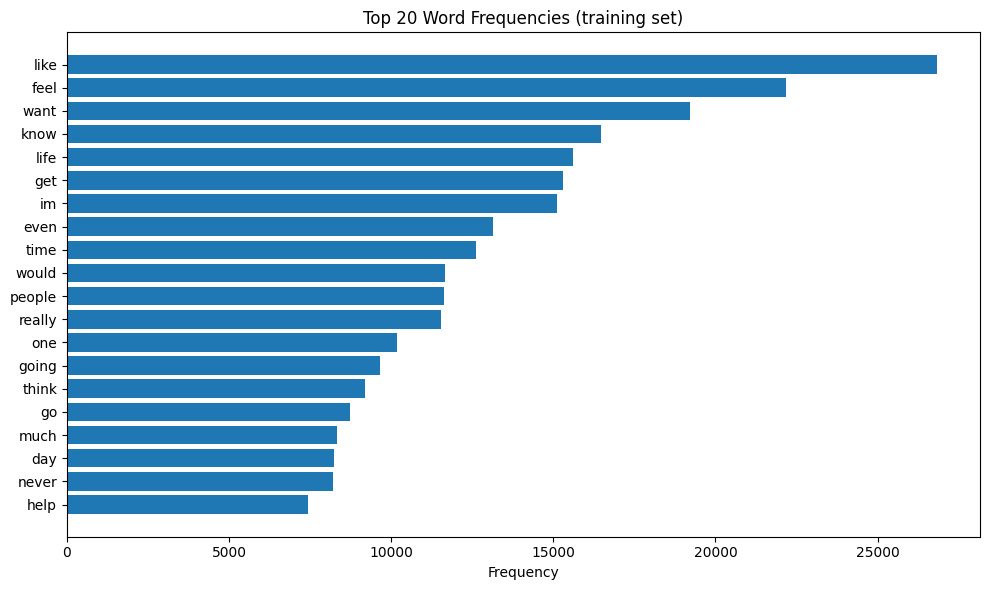

In [40]:
tokens, counts = zip(*vocab.most_common(20))

plt.figure(figsize=(10,6))
plt.barh(tokens[::-1], counts[::-1])
plt.xlabel('Frequency')
plt.title(f'Top {20} Word Frequencies (training set)')
plt.tight_layout()
plt.savefig('top20_word_freq.png', dpi=300, bbox_inches='tight')
plt.show()

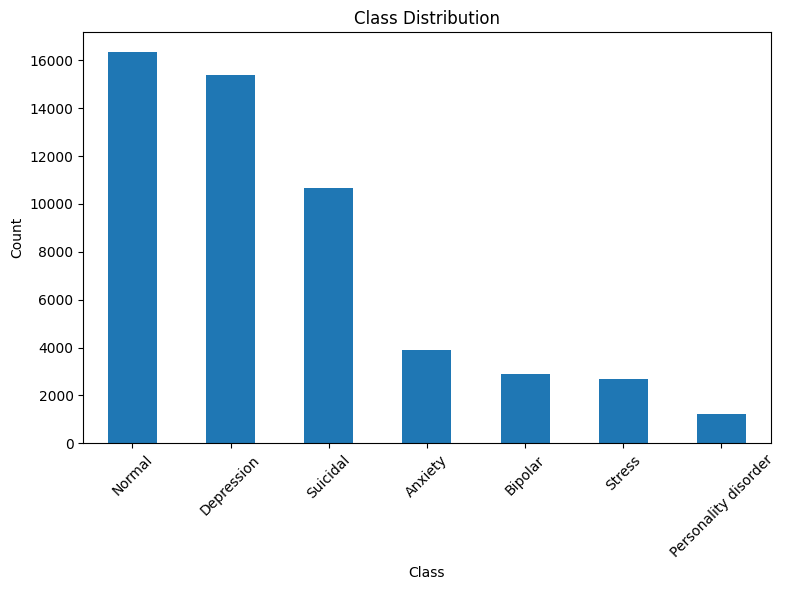

In [41]:

class_counts = data['status'].value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Using Pretrained word embeddings, GloVe

We will use a GloVe file from Stanford that is pre-trained using twitter data, which should be analagous to the statements we are trying to analyze. You can find this file, and other pre-trained embeddings here: https://nlp.stanford.edu/projects/glove/

Make sure you download and upload the file to this notebook before use.

This next cell will create our embedding dictionary that will correspond our vocab to a real number vector of size 100. This will be used to create the embedding layer so we can begin creating our CNN.

In [13]:
glove_path = "/content/drive/MyDrive/STAT4744_Final/glove.twitter.27B.100d.txt"

glove_dict = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        parts = line.rstrip().split(' ')
        word = parts[0]
        vec  = np.asarray(parts[1:], dtype='float32')
        glove_dict[word] = vec
embedding_dim = len(next(iter(glove_dict.values())))

Creating embeddding matrix and ensuring pad 0's and unknown 1's are set. We will also zero out the padding vector.



In [14]:
#create embedding matrix, given the vocab dictionary, glove dictionary, and embedding vector size
def make_embedding_matrix(vocab_to_index, glove_dict, embedding_dim):
  embedding_mat = np.random.uniform(-.25, .25, size = (vocab_size, embedding_dim))
  embedding_mat[0] = np.zeros(embedding_dim)

  for word, index in vocab_to_index.items():
    if word in glove_dict:
      embedding_mat[index] = glove_dict[word]
    else:
      continue #keep the random uniform vector if unk

  return embedding_mat

embedding_mat = make_embedding_matrix(vocab_to_index, glove_dict, embedding_dim)

now that we have established the embedding matrix, the last thing we need to do is tranform our tokenized statements into a rectangular matrix. We will make an encoding function using our dictionary to translate words to integers. Statements longer than 100 words will be cut short, where as shorter statements will be padded with zeros.

In [15]:
def encode(tokens, vocab_to_index, embedding_dim):
  tokens = tokens.split(' ')
  indices = [vocab_to_index[token] if token in vocab_to_index else 1 for token in tokens]
  indices = indices[:embedding_dim]
  if len(indices) < embedding_dim:
    indices += [0] * (embedding_dim - len(indices))
  return indices


We can encode our text, and then define and X matrix and y vector to be used in our model from our training dataset. We also need to transform these X and y arrays to tensors.

In [16]:
train_data['token_ids'] = train_data['tokenized_statement'].apply(lambda x: encode(x, vocab_to_index, embedding_dim))
val_data['token_ids'] = val_data['tokenized_statement'].apply(lambda x: encode(x, vocab_to_index, embedding_dim))
test_data['token_ids'] = test_data['tokenized_statement'].apply(lambda x: encode(x, vocab_to_index, embedding_dim))

X_train = np.stack(train_data['token_ids'].values)
y_train = train_data['status_encoded'].values

X_val = np.stack(val_data['token_ids'].values)
y_val = val_data['status_encoded'].values

X_test = np.stack(test_data['token_ids'].values)
y_test = test_data['status_encoded'].values

X_train.shape, y_train.shape

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

###Dataloaders

creating dataloaders for the model from tensors

In [17]:
test_iter = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)
val_iter = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)
train_iter = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=False)


Creating the embedding layer using the matrix.

In [18]:
embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_mat, dtype = torch.float32), freeze=False, padding_idx=0)

source for batch-norm; pmlr-v37-ioffe15

# Defining CNN architecture

In [19]:
class TextCNN(nn.Module):
  def __init__(self, embedding_layer, num_classes = 7, dropout = 0.2):
    super(TextCNN, self).__init__()
    self.embedding = embedding_layer
    max_len = embedding_layer.embedding_dim

    self.conv1 = nn.Conv1d(max_len, 16, kernel_size=3, stride=1, padding = 0)
    self.bn1 = nn.BatchNorm1d(16) #cite from above
    self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding = 0)
    self.bn2 = nn.BatchNorm1d(32)
    self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

    self.dropout = nn.Dropout(dropout)

    #used chat gpt to help calculate tensor sizes
    self.fc1 = nn.Linear(32 * 23, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):

    x = self.embedding(x.long())   # B, max_len, E
    x = x.transpose(1, 2)

    # Conv block 1
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.dropout(x)

    # Conv block 2
    x = self.conv2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = self.dropout(x)

    # Flatten
    x = x.view(x.size(0), -1)

    # Fully connected
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    # Return probabilities
    return F.softmax(x, dim=1)

## Training function for CNN (with graphing)
Training function, mostly copied from hW3, with adjustments made to track validation loss, added early stopping, and handling the matrix of data.

In [70]:
def train(train_iter, val_iter, net, optimizer, device, num_epochs = 50, patience = 5):
    net = net.to(device)
    print("training on", device)
    # Cross entropy
    counts = Counter(y_train_tensor.tolist())
    total = sum(counts.values())
    print(counts)
    class_weights = torch.tensor([total/counts[i] for i in range(7)],
                             dtype=torch.float32, device=device)
    loss = torch.nn.CrossEntropyLoss(weight=class_weights)
    batch_count = 0

    #for keeping track of training metadata
    train_losses = []
    train_accs = []
    val_accs = []
    val_losses = []
    epoch_times = []

    #for early stopping
    epoch_not_improved_in = 0
    min_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for  X, y in tqdm(train_iter, desc=f"Epoch {epoch+1}/{num_epochs}"):
          #input attributes and tags
          X = X.long().to(device)
          y = y.long().to(device)

          #forecast, then calculate loss
          y_hat = net(X)
          l = loss(y_hat, y)
          optimizer.zero_grad()
          l.backward()
          optimizer.step()

          train_l_sum += l.cpu().item() * X.size(0)
          train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
          n += y.size(0)
          batch_count += 1

        epoch_loss = train_l_sum / n #might need to make this len(train_iter)
        epoch_acc = train_acc_sum / n
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        epoch_times.append(time.time()-start)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.3f}, Time: {time.time()-start:.2f} sec")

        #evaluate on the validation set, some differences between two models. First place to search for errors should be here
        net.eval()
        val_loss, val_acc_sum, val_total = 0.0, 0, 0

        with torch.no_grad():
          for X, y in val_iter:
            X = X.long().to(device)
            y = y.long().to(device)
            y_hat = net(X)
            l = loss(y_hat, y)

            val_loss += l.cpu().item() * X.size(0)
            val_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            val_total += y.size(0)
        val_loss = val_loss / val_total
        val_acc = val_acc_sum / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f'Epoch {epoch+1}/{num_epochs} — '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        #implenting early stopping
        if val_loss < min_val_loss:
          min_val_loss = val_loss
          epcoh_not_improved_in = 0
        else:
          epoch_not_improved_in += 1
        if epoch_not_improved_in >= patience:
          print(f'Early stopping at epoch {epoch+1}')
          break

    epochs = range(1, len(train_losses) + 1)
    print('epochs: ', epochs)
    print('train_losses: ', train_losses)
    print('train_accs: ', train_accs)
    print('val_losses: ', val_losses)
    print('val_accs: ', val_accs)
    plt.figure(figsize=(10, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.plot(epochs, val_losses,   'o-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Training and Validation Loss vs. Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, marker='o', label="Train Acc")
    plt.plot(epochs, val_accs, marker='o', label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train and Validation Accuracy vs. Epoch")
    plt.legend()

    plt.tight_layout()
    plt.savefig('loss_acc_graph.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Final Validation Accuracy:", val_accs[-1])

    return train_losses, train_accs, val_losses, val_accs, epoch_times

##Evaluate accuracy function

In [21]:
def evaluate_accuracy(data_iter, net, device = None):
  if device is None and isinstance(net, torch.nn.Module):
    device = list(net.parameters())[0].device
  acc_sum, n = 0.0, 0
  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(net, torch.nn.Module):
        net.eval()
        acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
        net.train()
      else:
        if ('is_training' in net.__code__.co_varnames):
          acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
        else:
          acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
      n += y.shape[0]
  return acc_sum / n

training on cuda
Counter({0: 11446, 1: 10783, 2: 7457, 3: 2721, 4: 2014, 5: 1868, 6: 841})


Epoch 1/50: 100%|██████████| 581/581 [00:02<00:00, 241.38it/s]


Epoch 1, Loss: 1.6856, Train Accuracy: 0.547, Time: 2.41 sec
Epoch 1/50 — Val Loss: 1.5782, Val Acc: 0.6522


Epoch 2/50: 100%|██████████| 581/581 [00:02<00:00, 220.76it/s]


Epoch 2, Loss: 1.5590, Train Accuracy: 0.668, Time: 2.64 sec
Epoch 2/50 — Val Loss: 1.5475, Val Acc: 0.6724


Epoch 3/50: 100%|██████████| 581/581 [00:02<00:00, 213.48it/s]


Epoch 3, Loss: 1.5094, Train Accuracy: 0.698, Time: 2.73 sec
Epoch 3/50 — Val Loss: 1.4939, Val Acc: 0.7052


Epoch 4/50: 100%|██████████| 581/581 [00:02<00:00, 243.81it/s]


Epoch 4, Loss: 1.4597, Train Accuracy: 0.715, Time: 2.39 sec
Epoch 4/50 — Val Loss: 1.4902, Val Acc: 0.6739


Epoch 5/50: 100%|██████████| 581/581 [00:02<00:00, 245.16it/s]


Epoch 5, Loss: 1.4280, Train Accuracy: 0.732, Time: 2.37 sec
Epoch 5/50 — Val Loss: 1.4613, Val Acc: 0.7031


Epoch 6/50: 100%|██████████| 581/581 [00:02<00:00, 246.04it/s]


Epoch 6, Loss: 1.4096, Train Accuracy: 0.744, Time: 2.36 sec
Epoch 6/50 — Val Loss: 1.4578, Val Acc: 0.6865


Epoch 7/50: 100%|██████████| 581/581 [00:02<00:00, 204.76it/s]


Epoch 7, Loss: 1.3915, Train Accuracy: 0.755, Time: 2.84 sec
Epoch 7/50 — Val Loss: 1.4562, Val Acc: 0.6900


Epoch 8/50: 100%|██████████| 581/581 [00:02<00:00, 233.08it/s]


Epoch 8, Loss: 1.3817, Train Accuracy: 0.762, Time: 2.50 sec
Epoch 8/50 — Val Loss: 1.4471, Val Acc: 0.7111


Epoch 9/50: 100%|██████████| 581/581 [00:02<00:00, 249.13it/s]


Epoch 9, Loss: 1.3716, Train Accuracy: 0.771, Time: 2.34 sec
Epoch 9/50 — Val Loss: 1.4439, Val Acc: 0.6998


Epoch 10/50: 100%|██████████| 581/581 [00:02<00:00, 241.50it/s]


Epoch 10, Loss: 1.3657, Train Accuracy: 0.777, Time: 2.41 sec
Epoch 10/50 — Val Loss: 1.4516, Val Acc: 0.6955


Epoch 11/50: 100%|██████████| 581/581 [00:02<00:00, 251.13it/s]


Epoch 11, Loss: 1.3609, Train Accuracy: 0.780, Time: 2.32 sec
Epoch 11/50 — Val Loss: 1.4452, Val Acc: 0.6966


Epoch 12/50: 100%|██████████| 581/581 [00:03<00:00, 193.05it/s]


Epoch 12, Loss: 1.3577, Train Accuracy: 0.785, Time: 3.01 sec
Epoch 12/50 — Val Loss: 1.4464, Val Acc: 0.7098


Epoch 13/50: 100%|██████████| 581/581 [00:02<00:00, 246.94it/s]


Epoch 13, Loss: 1.3546, Train Accuracy: 0.790, Time: 2.36 sec
Epoch 13/50 — Val Loss: 1.4437, Val Acc: 0.7059


Epoch 14/50: 100%|██████████| 581/581 [00:02<00:00, 234.21it/s]


Epoch 14, Loss: 1.3476, Train Accuracy: 0.795, Time: 2.48 sec
Epoch 14/50 — Val Loss: 1.4413, Val Acc: 0.7056


Epoch 15/50: 100%|██████████| 581/581 [00:02<00:00, 246.18it/s]


Epoch 15, Loss: 1.3435, Train Accuracy: 0.795, Time: 2.36 sec
Epoch 15/50 — Val Loss: 1.4423, Val Acc: 0.7180


Epoch 16/50: 100%|██████████| 581/581 [00:02<00:00, 221.50it/s]


Epoch 16, Loss: 1.3374, Train Accuracy: 0.803, Time: 2.63 sec
Epoch 16/50 — Val Loss: 1.4455, Val Acc: 0.7190
Early stopping at epoch 16
epochs:  range(1, 17)
train_losses:  [1.6855896980653964, 1.5590348297522905, 1.5093567224580131, 1.4597497032300628, 1.4280119173551806, 1.409563979093129, 1.3914906926210313, 1.381720143709098, 1.3716020622761975, 1.3656795611960721, 1.3608951246452692, 1.357657550410572, 1.3545861449486927, 1.3476337626716888, 1.3435210533935749, 1.3373737255453968]
train_accs:  [0.5474818206302181, 0.6683274979800701, 0.6980608672232695, 0.7152168058173983, 0.7324266092108807, 0.7444384594667385, 0.754915162941018, 0.7622946404524643, 0.7712900619445192, 0.7773498518718017, 0.7800969566388365, 0.7852679773767842, 0.7901696741179639, 0.7948289792620522, 0.7952868300565581, 0.8026663075680043]
val_losses:  [1.57818281242798, 1.5475246443634176, 1.4938787827212225, 1.4902465591226042, 1.4613324160935024, 1.4578341971887208, 1.4561720590144516, 1.4470559474606202, 1.4

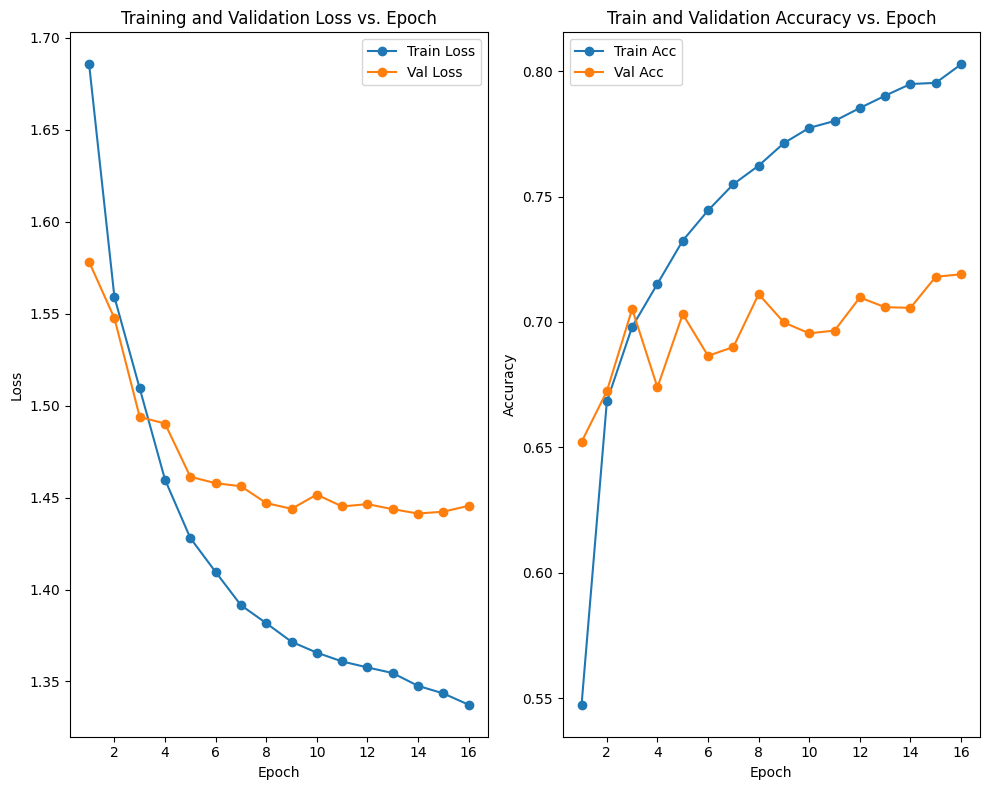

Final Validation Accuracy: 0.7190052967052698


In [77]:
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_mat, dtype = torch.float32), freeze=False, padding_idx=0)

net = TextCNN(embedding_layer)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
CNN_train_losses, CNN_train_accs, CNN_val_losses, CNN_val_accs, CNN_epoch_times = train(train_iter, val_iter, net, optimizer, device)

In [79]:
test_acc = evaluate_accuracy(test_iter, net, device)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7344


## Confusion matrix

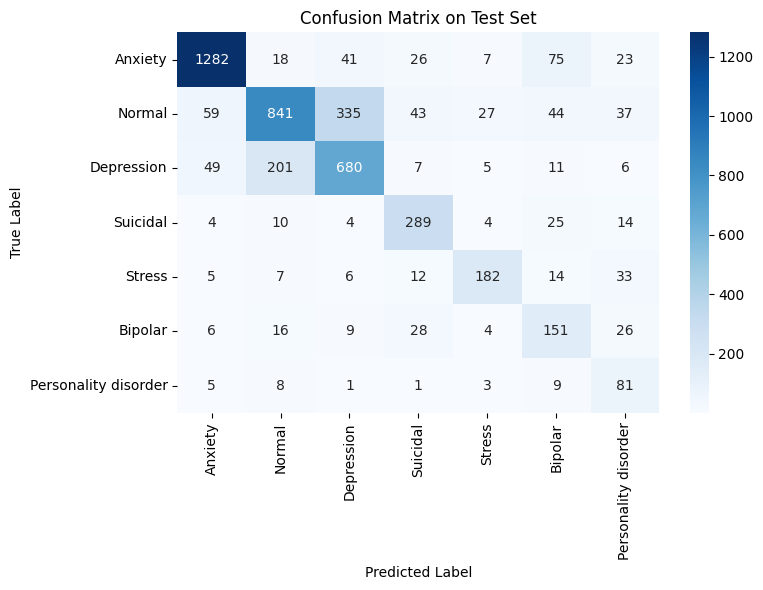

In [80]:
from sklearn.metrics import confusion_matrix
class_names = list(data['status'].unique())
net.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_iter:
        X = X.long().to(device)
        y = y.long().to(device)
        preds = net(X).argmax(dim=1).cpu().numpy()
        labels = y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
list(class_names)

['Anxiety',
 'Normal',
 'Depression',
 'Suicidal',
 'Stress',
 'Bipolar',
 'Personality disorder']

In [81]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds,
      target_names=class_names, zero_division=0))

                      precision    recall  f1-score   support

             Anxiety       0.91      0.87      0.89      1472
              Normal       0.76      0.61      0.68      1386
          Depression       0.63      0.71      0.67       959
            Suicidal       0.71      0.83      0.76       350
              Stress       0.78      0.70      0.74       259
             Bipolar       0.46      0.63      0.53       240
Personality disorder       0.37      0.75      0.49       108

            accuracy                           0.73      4774
           macro avg       0.66      0.73      0.68      4774
        weighted avg       0.76      0.73      0.74      4774



In [83]:
report_dict = classification_report(
    all_labels, all_preds,
    target_names=class_names,
    output_dict=True
)
df = pd.DataFrame(report_dict).transpose()

# save to CSV
df.to_csv('classification_report.csv', float_format='%.4f')

with open('report_table.tex', 'w') as f:
    f.write(df.to_latex(
        caption="Classification Report",
        label="tab:class-report",
        float_format="%.2f",
        header=True,
        index=True,
        bold_rows=True
    ))